In [1]:
# neede libraries
import numpy as np
import pandas as pd 
import ast
import wordcloud
import matplotlib.pyplot as plt
import seaborn as sns
import pycountry 
import geopandas
import datetime
from wordcloud import WordCloud
from sklearn.model_selection import KFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

import xgboost
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import pickle

In [2]:
# load data from a csv file
df = pd.read_csv('../data/clean_movies.csv')
df = df.drop('Unnamed: 0', 1)

/var/folders/9h/f_x4v9yn501dvc2jkc54t6fw0000gn/T/ipykernel_84681/237138807.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df = df.drop('Unnamed: 0', 1)


In [3]:
df.isna().sum()

rating              360
genre                 0
score                 0
votes                 0
director              0
writer                3
star                  0
country               1
budget                0
company              10
runtime               0
released_year         0
released_month        0
released_weekday      0
name_length           0
gross                 0
dtype: int64

In [4]:
y = df['gross'] # remember, we want to predict who earns more than 50k or less than 50k
X = df.loc[:, df.columns != 'gross'] # all other columns are features

In [5]:
# collect which encoder to use on each feature
# needs to be done manually

onehot_ftrs = ['rating','genre','director','writer','star','country', 'company', 'released_year','released_month','released_weekday']
minmax_ftrs = ['score','runtime']
std_ftrs = ['votes', 'budget', 'name_length']

# one-hot encoder
# We need to replace the NaN with a string first!
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant',fill_value='missing')),
    ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'))])


# standard scaler
std_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# minmax scaler
minmax_transformer = Pipeline(steps=[
    ('minmax', MinMaxScaler())])


# collect the transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, onehot_ftrs),
        ('std', std_transformer, std_ftrs),
        ('minmax', minmax_transformer, minmax_ftrs)])

clf = Pipeline(steps=[('preprocessor', preprocessor)])

In [6]:
rs=50

def RF_pipeline(X,y,random_state_r):
    # create a test set
    
    all_rmse = np.zeros(random_state_r)
    all_baseline_rmse = np.zeros(random_state_r)
    all_models = []
    
    all_X_test = []
    all_y_test = []
    
    for i in range(random_state_r):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42*i)

        
        
        y_test_baseline = np.full(y_test.shape, np.mean(y_train))

        X_train = clf.fit_transform(X_train)
        X_test = clf.transform(X_test)
        
        all_X_test.append(X_test)
        all_y_test.append(y_test)
        
        feature_names = list(preprocessor.named_transformers_['cat'][1].get_feature_names(onehot_ftrs)) + \
                        preprocessor.transformers_[1][-1] + \
                        preprocessor.transformers_[2][-1]
    
        rf_best = RandomForestRegressor(max_depth = 100, max_features = 0.4, random_state=42*i)
    
        rf_best.fit(X_train, y_train)
    
        y_test_pred = rf_best.predict(X_test)
    
        all_rmse[i] = np.sqrt(mean_squared_error(y_test,y_test_pred))
        all_baseline_rmse[i] = np.sqrt(mean_squared_error(y_test,y_test_baseline))

        all_models.append(rf_best)
        
    return all_models, all_rmse, all_baseline_rmse, all_X_test, all_y_test, feature_names

all_models, all_rmse, all_baseline_rmse, all_X_test, all_y_test, feature_names = RF_pipeline(X,y,rs)

print(all_rmse)
print(all_baseline_rmse)
print(feature_names)

[8.13950837e+07 8.62653635e+07 9.26110323e+07 7.52988708e+07
 6.84403408e+07 8.41201074e+07 7.09391805e+07 7.22145397e+07
 7.53281452e+07 8.32876304e+07 7.10223038e+07 7.78204259e+07
 8.47757321e+07 8.79750609e+07 9.19228839e+07 8.10698963e+07
 8.11520443e+07 7.45490864e+07 7.25701800e+07 9.00919730e+07
 7.73518620e+07 8.41190843e+07 8.50726109e+07 7.70039926e+07
 9.16492607e+07 8.39162112e+07 8.16683647e+07 7.07920695e+07
 9.07020771e+07 9.27578030e+07 8.26773805e+07 8.37629355e+07
 6.45675002e+07 1.00860453e+08 7.35984107e+07 6.58099562e+07
 8.31948959e+07 7.08877511e+07 7.76117906e+07 7.65015178e+07
 7.52513447e+07 7.48190819e+07 8.70160304e+07 7.34707006e+07
 8.14085855e+07 8.52575590e+07 7.41574349e+07 8.84622350e+07
 9.33902540e+07 8.13133698e+07]
[1.59354166e+08 1.74527854e+08 1.74265193e+08 1.59601598e+08
 1.38486667e+08 1.66464032e+08 1.41761796e+08 1.49327690e+08
 1.64859685e+08 1.69391675e+08 1.50738095e+08 1.63688764e+08
 1.69697138e+08 1.73177149e+08 1.90481552e+08 1.72832

In [7]:

print(f"{np.mean(all_rmse)} ± {np.std(all_rmse)}")
print(f"{np.mean(all_baseline_rmse)} ± {np.std(all_baseline_rmse)}")


80638048.08528966 ± 7888583.503783009
164717974.42342967 ± 11670558.738955721


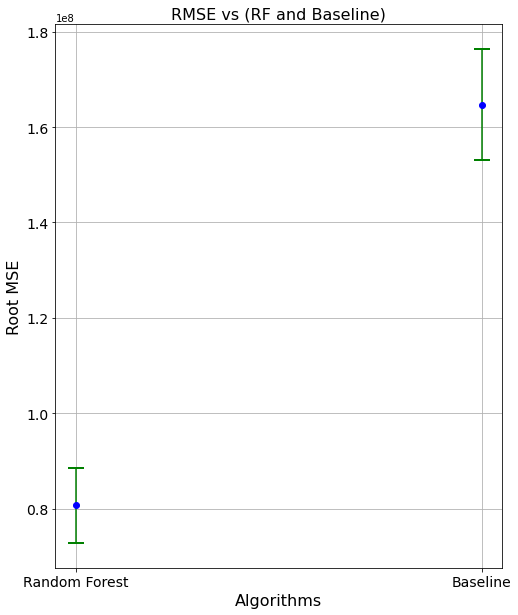

In [8]:

mean_rmse = [np.mean(all_rmse),np.mean(all_baseline_rmse)]
std_rmse = [np.std(all_rmse),np.std(all_baseline_rmse)]
labels = ["Random Forest", "Baseline"]


plt.figure(figsize=(8,10))
plt.errorbar(np.arange(2), mean_rmse, yerr=std_rmse, fmt='o', ecolor='g', color = 'b',capthick=2,capsize=8)
plt.grid()
plt.xticks(np.arange(2), labels)
plt.xlabel('Algorithms', fontsize = 16)
plt.ylabel('Root MSE', fontsize = 16)
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.title('RMSE vs (RF and Baseline)', fontsize = 16)

plt.savefig('../figures/RMSE_by_50_different.png', dpi=300, format='png')
plt.show()

**Permutation feature Importance**

In [9]:
def RF_pipeline_kfold(X,y,random_state,n_folds):
    # create a test set
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, random_state = random_state)
    # splitter for _other
    kf = KFold(n_splits=n_folds,shuffle=True,random_state=random_state)

    pipe = make_pipeline(preprocessor,RandomForestRegressor(random_state=random_state))

    param_grid = {'randomforestregressor__max_depth': [100],
                  'randomforestregressor__max_features': [0.4]}
    # prepare gridsearch
    grid = GridSearchCV(pipe, param_grid=param_grid,cv=kf, return_train_score = True,n_jobs=-1,verbose=10)
    # do kfold CV on _other
    grid.fit(X_other, y_other)
    return grid, X_test, y_test








grid, X_test, y_test = RF_pipeline_kfold(X,y,42,5)



ftr_names = X.columns
np.random.seed(42)

nr_runs = 10
scores = np.zeros([len(ftr_names),nr_runs])

test_score = grid.score(X_test,y_test)
print('test score = ',test_score)

print('test baseline = ',np.sum(y_test == 0)/len(y_test))
# loop through the features
for i in range(len(ftr_names)):
    print('shuffling '+str(ftr_names[i]))
    acc_scores = []
    for j in range(nr_runs):
        X_test_shuffled = X_test.copy()
        X_test_shuffled[ftr_names[i]] = np.random.permutation(X_test[ftr_names[i]].values)
        acc_scores.append(grid.score(X_test_shuffled,y_test))
    print('   shuffled test score:',np.around(np.mean(acc_scores),3),'+/-',np.around(np.std(acc_scores),3))
    scores[i] = acc_scores


Fitting 5 folds for each of 1 candidates, totalling 5 fits
test score =  0.7554979246458231
test baseline =  0.0
shuffling rating
   shuffled test score: 0.71 +/- 0.011
shuffling genre
   shuffled test score: 0.737 +/- 0.003
shuffling score
   shuffled test score: 0.723 +/- 0.003
shuffling votes
   shuffled test score: 0.289 +/- 0.02
shuffling director
   shuffled test score: 0.755 +/- 0.0
shuffling writer
   shuffled test score: 0.756 +/- 0.0
shuffling star
   shuffled test score: 0.755 +/- 0.0
shuffling country
   shuffled test score: 0.749 +/- 0.001
shuffling budget
   shuffled test score: 0.349 +/- 0.018
shuffling company
   shuffled test score: 0.75 +/- 0.003
shuffling runtime
   shuffled test score: 0.706 +/- 0.006
shuffling released_year
   shuffled test score: 0.749 +/- 0.001
shuffling released_month
   shuffled test score: 0.747 +/- 0.005
shuffling released_weekday
   shuffled test score: 0.752 +/- 0.002
shuffling name_length
   shuffled test score: 0.755 +/- 0.004


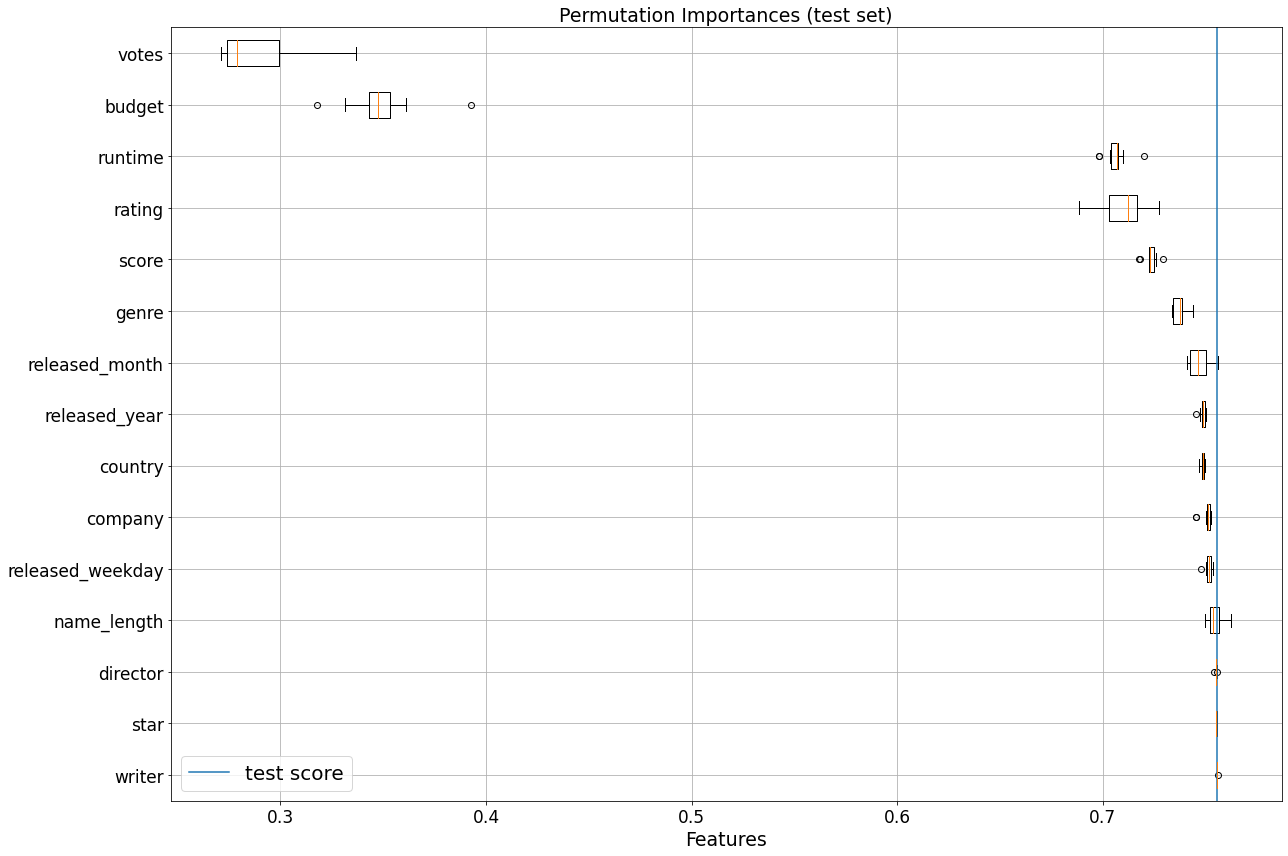

In [10]:
sorted_indcs = np.argsort(np.mean(scores,axis=1))[::-1]
plt.figure(figsize=(18,12))
plt.boxplot(scores[sorted_indcs].T,labels=ftr_names[sorted_indcs],vert=False)
plt.axvline(test_score,label='test score')
plt.title("Permutation Importances (test set)",fontsize = 19)
plt.xlabel('Score with perturbed feature',fontsize = 19)
plt.xlabel('Features',fontsize = 19)
plt.grid()
plt.tick_params(axis='x', labelsize=17)
plt.tick_params(axis='y', labelsize=17)
plt.legend(fontsize=20)
plt.tight_layout()

plt.savefig('../figures/Permutation Global Importance.png', dpi=300, format='png')
plt.show()

**random forest_feature importance**

In [11]:
import time
import numpy as np

forest=all_models[-1]

start_time = time.time()
importances = pd.DataFrame(forest.feature_importances_)
std = pd.DataFrame(np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0))
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.012 seconds


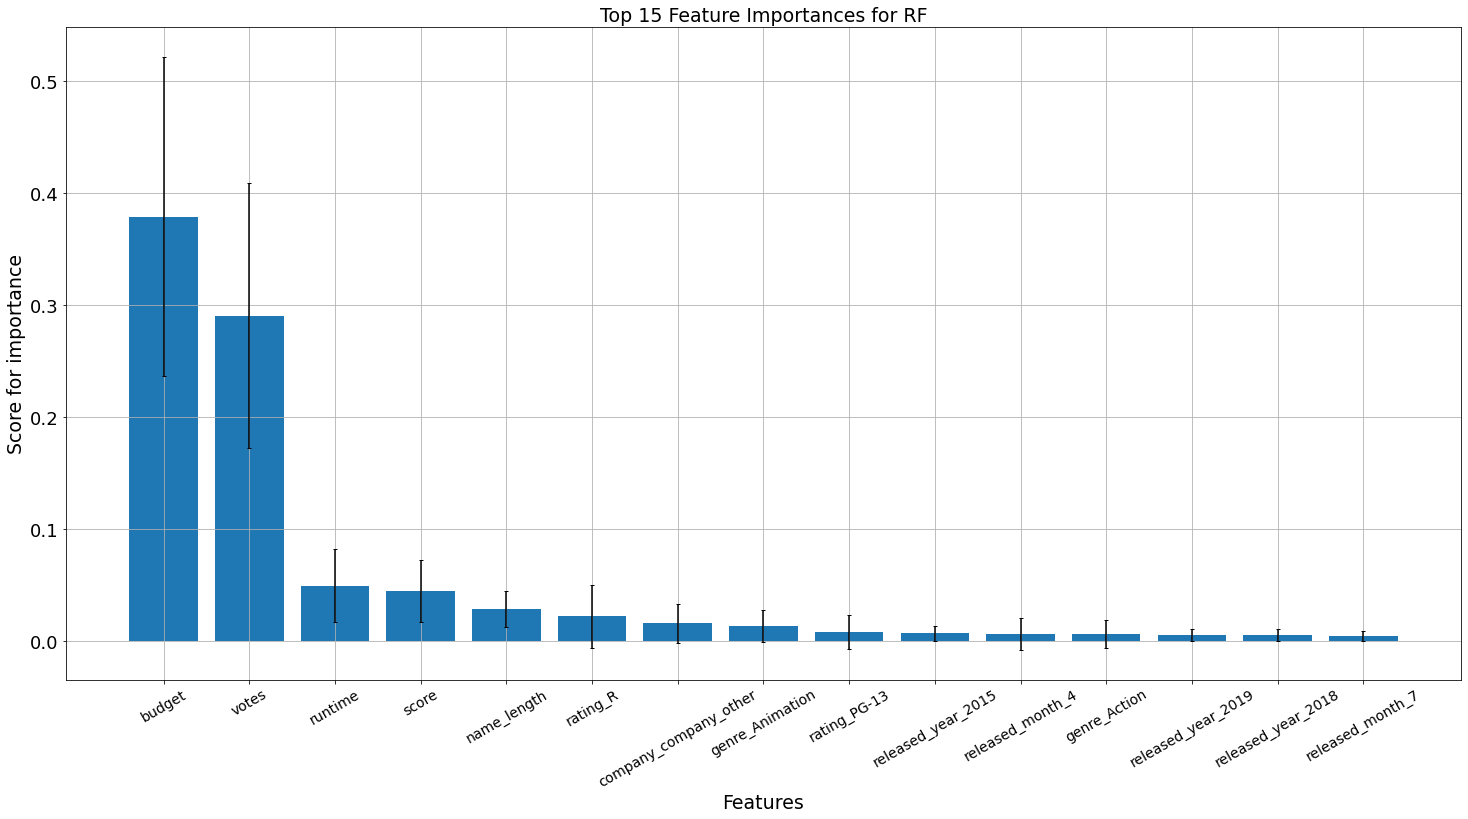

In [12]:
import pandas as pd

importances.index = feature_names
std.index = feature_names

forest = pd.concat([importances, std], axis=1)
forest.columns=['import','std']

forest = forest.sort_values(by=['import'], ascending=False)
forest_15=forest[:15]



plt.figure(figsize=(25,12))
plt.bar(forest_15.index.values,forest_15['import'],yerr=forest_15['std'], capsize=2)
plt.title("Top 15 Feature Importances for RF",fontsize = 19)
plt.xlabel('Features',fontsize = 19)
plt.ylabel('Score for importance',fontsize = 19)
plt.grid()
plt.xticks(rotation=30)
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=18)

plt.savefig('../figures/RF feature Importance.png', dpi=300, format='png')
plt.show()

In [13]:

rs=50

def xg_pipeline(X,y,random_state_r):
    # create a test set
    
    all_rmse = np.zeros(random_state_r)
    all_baseline_rmse = np.zeros(random_state_r)
    all_models = []
    
    all_X_test = []
    all_y_test = []
    
    for i in range(random_state_r):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42*i)

        
        
        y_test_baseline = np.full(y_test.shape, np.mean(y_train))

        X_train = clf.fit_transform(X_train)
        X_test = clf.transform(X_test)
        
        all_X_test.append(X_test)
        all_y_test.append(y_test)
        
        feature_names = list(preprocessor.named_transformers_['cat'][1].get_feature_names(onehot_ftrs)) + \
                        preprocessor.transformers_[1][-1] + \
                        preprocessor.transformers_[2][-1]
    
        xg_best = xgboost.XGBRegressor(learning_rate = 0.03, seed = 0, max_depth=10, colsample_bytree = 0.9, subsample=0.66)
        


    
        xg_best.fit(X_train, y_train)
    
        y_test_pred = xg_best.predict(X_test)
    
        all_rmse[i] = np.sqrt(mean_squared_error(y_test,y_test_pred))
        all_baseline_rmse[i] = np.sqrt(mean_squared_error(y_test,y_test_baseline))

        all_models.append(xg_best)
        
    return all_models, all_rmse, all_baseline_rmse, all_X_test, all_y_test, feature_names

all_models, all_rmse, all_baseline_rmse, all_X_test, all_y_test, feature_names = xg_pipeline(X,y,rs)

print(all_rmse)
print(all_baseline_rmse)
print(feature_names)

[8.03910262e+07 8.71554436e+07 9.28081302e+07 7.68961299e+07
 6.74576350e+07 8.40491481e+07 6.93229672e+07 7.38003772e+07
 7.55894497e+07 7.76330337e+07 7.04655767e+07 7.27883938e+07
 8.51214681e+07 8.62427817e+07 9.18675051e+07 7.70467145e+07
 8.06047576e+07 7.50413829e+07 7.35988919e+07 8.68739117e+07
 7.63089520e+07 8.29208218e+07 8.32335680e+07 7.71824059e+07
 9.12425853e+07 8.08451281e+07 8.06265389e+07 7.02644147e+07
 8.97557712e+07 9.09467534e+07 7.74788175e+07 8.24750637e+07
 6.26722765e+07 1.02897433e+08 7.53308231e+07 6.96520891e+07
 8.27402485e+07 7.30778816e+07 7.44270999e+07 7.66886944e+07
 7.44666480e+07 7.45741623e+07 8.47553509e+07 7.51655385e+07
 8.23744764e+07 8.48754603e+07 7.21390674e+07 9.11045243e+07
 9.31910055e+07 8.17849994e+07]
[1.59354166e+08 1.74527854e+08 1.74265193e+08 1.59601598e+08
 1.38486667e+08 1.66464032e+08 1.41761796e+08 1.49327690e+08
 1.64859685e+08 1.69391675e+08 1.50738095e+08 1.63688764e+08
 1.69697138e+08 1.73177149e+08 1.90481552e+08 1.72832

In [14]:
import time
import numpy as np

forest=all_models[-1]



start_time = time.time()
importances = pd.DataFrame(forest.feature_importances_)



In [15]:
importances.index = feature_names
importances

,0
rating_Approved,0.000079
rating_G,0.004632
rating_NC-17,0.001854
rating_PG,0.005582
rating_PG-13,0.003799
...,...
votes,0.061420
budget,0.159773
name_length,0.009219
score,0.011598


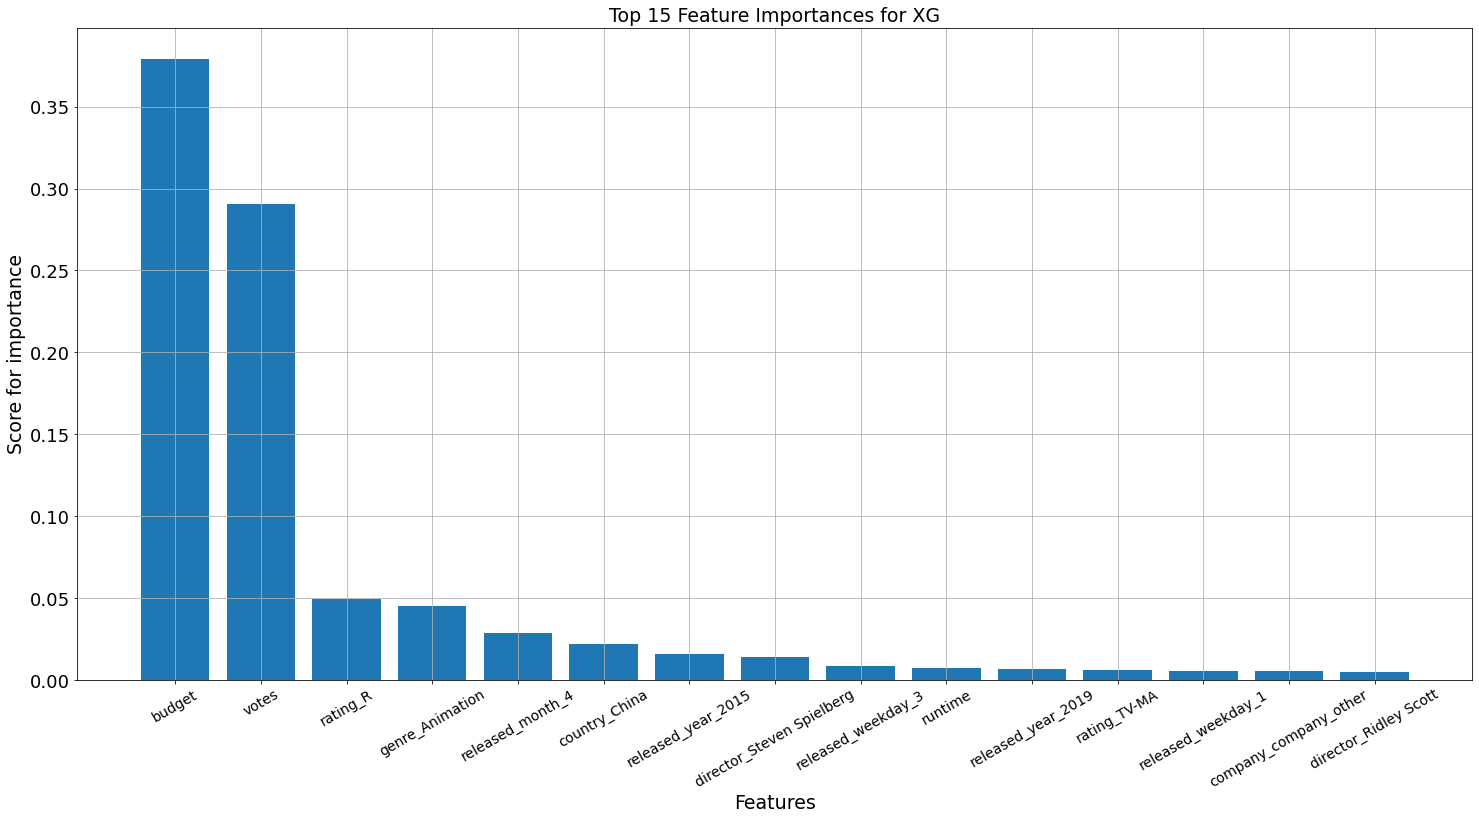

In [16]:
import pandas as pd

importances.index = feature_names
importances.columns=['import']

importances = importances.sort_values(by=['import'], ascending=False)
importances_15=importances[:15]



plt.figure(figsize=(25,12))
plt.bar(importances_15.index.values,forest_15['import'])
plt.title("Top 15 Feature Importances for XG",fontsize = 19)
plt.xlabel('Features',fontsize = 19)
plt.ylabel('Score for importance',fontsize = 19)
plt.grid()
plt.xticks(rotation=30)
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=18)

plt.savefig('../figures/XG feature Importance.png', dpi=300, format='png')
plt.show()

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42*i)

        
y_test_baseline = np.full(y_test.shape, np.mean(y_train))

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)


        
feature_names = list(preprocessor.named_transformers_['cat'][1].get_feature_names(onehot_ftrs)) + \
                        preprocessor.transformers_[1][-1] + \
                        preprocessor.transformers_[2][-1]
    
rf_best = RandomForestRegressor(max_depth = 100, max_features = 0.4, random_state=42*i)
rf_best.fit(X_train, y_train)



RandomForestRegressor(max_depth=100, max_features=0.4, random_state=588)

[CV 2/5; 1/1] START randomforestregressor__max_depth=100, randomforestregressor__max_features=0.4
[CV 2/5; 1/1] END randomforestregressor__max_depth=100, randomforestregressor__max_features=0.4;, score=(train=0.965, test=0.738) total time=   1.8s
[CV 1/5; 1/1] START randomforestregressor__max_depth=100, randomforestregressor__max_features=0.4
[CV 1/5; 1/1] END randomforestregressor__max_depth=100, randomforestregressor__max_features=0.4;, score=(train=0.961, test=0.780) total time=   1.8s
[CV 5/5; 1/1] START randomforestregressor__max_depth=100, randomforestregressor__max_features=0.4
[CV 5/5; 1/1] END randomforestregressor__max_depth=100, randomforestregressor__max_features=0.4;, score=(train=0.964, test=0.782) total time=   1.8s


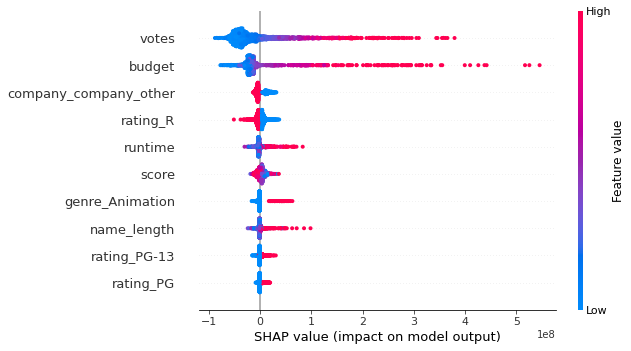

In [18]:

import shap

explainer = shap.TreeExplainer(rf_best)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names = feature_names, max_display=10,title="SHAP Summary Plot for RF")

In [19]:
import shap
shap.initjs()
i = 6

#print(X.iloc[i])
#print(shap_values[i,:])
#shap.force_plot(explainer.expected_value, shap_values[i], features=X_test.iloc[i], feature_names=feature_names)

index = 100 # the index of the point to explain

shap.force_plot(explainer.expected_value, shap_values[index,:], features = X_test[index,:],feature_names = feature_names)

[CV 3/5; 1/1] START randomforestregressor__max_depth=100, randomforestregressor__max_features=0.4
[CV 3/5; 1/1] END randomforestregressor__max_depth=100, randomforestregressor__max_features=0.4;, score=(train=0.968, test=0.737) total time=   1.9s
[CV 4/5; 1/1] START randomforestregressor__max_depth=100, randomforestregressor__max_features=0.4
[CV 4/5; 1/1] END randomforestregressor__max_depth=100, randomforestregressor__max_features=0.4;, score=(train=0.963, test=0.723) total time=   1.9s


print(X_test)

In [20]:
index = 200 # the index of the point to explain

shap.force_plot(explainer.expected_value, shap_values[index,:], features = X_test[index,:],feature_names = feature_names)